# UK Lotto Results Analysis

Author: Matthew Carter

## Introduction

The UK Lotto has been run by The National Lottery since 1994 and there are currently draws twice a week. Players choose six balls, aiming to match them with the six main balls in the draw to win the jackpot. Including a bonus ball, seven balls in total are drawn. Smaller prizes are won from matching two or more main balls.

In this analysis I look at the draws since the new Lotto format was introduced on the 8th October 2015, which increased the number of balls in the draw from 49 to 59.

## Importing the dataset

Lotto results for this project have been collected using my __[uk_lotto_scraper.py](https://github.com/MatthewCarterIO/uk-lotto-DA/blob/master/uk_lotto_scraper.py)__ file from the __[lottery.co.uk](https://www.lottery.co.uk/lotto/results)__ website (for personal use in this analysis only).

In [1]:
# Common Python packages that will be used throughout project.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from ast import literal_eval
from datetime import datetime
from collections import Counter
from itertools import combinations

In [2]:
# Import the draw results and convert the draw_date column into datetime 
# objects (type not preserved in the CSV file).
results_df = pd.read_csv("lotto_results.csv", parse_dates=["draw_date"])
results_df.head()

,draw_date,main_balls,bonus_ball
0,2015-12-30,"[22, 31, 47, 52, 55, 59]",23
1,2015-12-26,"[17, 21, 31, 38, 44, 58]",20
2,2015-12-23,"[1, 2, 4, 19, 28, 41]",32
3,2015-12-19,"[13, 14, 27, 46, 48, 50]",42
4,2015-12-16,"[10, 12, 35, 46, 48, 57]",14


In [3]:
# Confirm the data types of each column and ensure there are no missing values.
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546 entries, 0 to 545
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   draw_date   546 non-null    datetime64[ns]
 1   main_balls  546 non-null    object        
 2   bonus_ball  546 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 12.9+ KB


The `draw_date` column has successfully been converted into datetime data types. The `bonus_ball` column has been imported as the integers desired, however saving the DataFrame to a CSV file in __[uk_lotto_scraper.py](https://github.com/MatthewCarterIO/uk-lotto-DA/blob/master/uk_lotto_scraper.py)__ resulted in the `main_balls` column, which contained lists of integers for each draw, being stored as strings.

In [4]:
# Get data type of first row, main_balls column.
type(results_df.loc[0, "main_balls"])

str

In [5]:
# Function to convert string back into a list of integers.
def string_to_int_list(string_list):
    # Use literal_eval from ast module to evaluate the string into a list data 
    # type.
    return literal_eval(string_list)


# Apply function to each row of the main_balls column.
results_df["main_balls"] = results_df["main_balls"].apply(string_to_int_list)
# Get data type of first row, main_balls column.
type(results_df.loc[0, "main_balls"])

list

In this analysis the draw dates of interest are those after the 8th October 2015 when the new Lotto format was introduced, running to the present (25th March 2020 at time of last data collection).

In [6]:
# Sort the DataFrame into ascending date order and set the draw_date column as 
# the index.
results_df.sort_values(by=["draw_date"], inplace=True)
results_df.set_index("draw_date", inplace=True)
results_df.head()

,main_balls,bonus_ball
draw_date,,
2015-01-03,"[10, 15, 17, 18, 19, 31]",24
2015-01-07,"[4, 5, 10, 12, 20, 23]",24
2015-01-10,"[13, 14, 16, 24, 41, 43]",39
2015-01-14,"[17, 20, 28, 29, 33, 36]",23
2015-01-17,"[29, 37, 42, 46, 47, 49]",4


In [7]:
# Select rows in DataFrame between 8th October 2015 and 25th March 2020 by 
# taking a slice of the original DataFrame.
results_df = results_df["2015-10-08" : "2020-03-25"]
results_df

,main_balls,bonus_ball
draw_date,,
2015-10-10,"[2, 3, 16, 32, 53, 54]",8
2015-10-14,"[7, 13, 20, 27, 39, 52]",35
2015-10-17,"[8, 30, 37, 40, 46, 50]",36
2015-10-21,"[13, 14, 21, 25, 51, 53]",39
2015-10-24,"[29, 31, 43, 55, 58, 59]",11
...,...,...
2020-03-11,"[10, 39, 45, 46, 52, 54]",12
2020-03-14,"[7, 22, 30, 38, 42, 47]",14
2020-03-18,"[3, 7, 11, 19, 27, 52]",5


For analysis it will be useful to separate each of the six main balls into columns of their own.

In [8]:
# Create a new DataFrame containing just the main balls.
main_balls_df = pd.DataFrame(results_df["main_balls"].tolist(), 
                             index=results_df.index)
# Rename the columns.
main_balls_df.columns = [("ball_" + str(x)) for x in range(1, 7)]
# Combine this new DataFrame with the original results DataFrame.
results_df = pd.concat([results_df, main_balls_df], axis="columns")
results_df.head()

,main_balls,bonus_ball,ball_1,ball_2,ball_3,ball_4,ball_5,ball_6
draw_date,,,,,,,,
2015-10-10,"[2, 3, 16, 32, 53, 54]",8,2,3,16,32,53,54
2015-10-14,"[7, 13, 20, 27, 39, 52]",35,7,13,20,27,39,52
2015-10-17,"[8, 30, 37, 40, 46, 50]",36,8,30,37,40,46,50
2015-10-21,"[13, 14, 21, 25, 51, 53]",39,13,14,21,25,51,53
2015-10-24,"[29, 31, 43, 55, 58, 59]",11,29,31,43,55,58,59


Logically the bonus ball should come after the main balls in the DataFrame.

In [9]:
# Save the bonus_ball column as a Series.
bonus_ball_series = results_df["bonus_ball"]
# Remove the bonus_ball column from the DataFrame
results_df = results_df.drop(["bonus_ball"], axis="columns")
# Add the bonus_ball column once again at the end of the DataFrame.
results_df = pd.concat([results_df, bonus_ball_series], axis="columns")
results_df.head()

,main_balls,ball_1,ball_2,ball_3,ball_4,ball_5,ball_6,bonus_ball
draw_date,,,,,,,,
2015-10-10,"[2, 3, 16, 32, 53, 54]",2,3,16,32,53,54,8
2015-10-14,"[7, 13, 20, 27, 39, 52]",7,13,20,27,39,52,35
2015-10-17,"[8, 30, 37, 40, 46, 50]",8,30,37,40,46,50,36
2015-10-21,"[13, 14, 21, 25, 51, 53]",13,14,21,25,51,53,39
2015-10-24,"[29, 31, 43, 55, 58, 59]",29,31,43,55,58,59,11


The data is now filtered for the draws of interest and organised ready for analysis.

In [10]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 466 entries, 2015-10-10 to 2020-03-25
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   main_balls  466 non-null    object
 1   ball_1      466 non-null    int64 
 2   ball_2      466 non-null    int64 
 3   ball_3      466 non-null    int64 
 4   ball_4      466 non-null    int64 
 5   ball_5      466 non-null    int64 
 6   ball_6      466 non-null    int64 
 7   bonus_ball  466 non-null    int64 
dtypes: int64(7), object(1)
memory usage: 32.8+ KB


## Analysis

Lotto numbers are a categorical (nominal) data type. Their numbers are only identifiers which could easily be replaced with descriptors such as words, shapes or colours.

### The odds

The odds of winning the Lotto by matching all six main balls is often published and the combination function can be used to calculate it. The function is applicable where there is no repetition of numbers and when their order is irrelevant.

$ C(n,r) = \begin{pmatrix} n \\ r \end{pmatrix} = \frac{n!}{r!(n-r)!} $ 

Where:

$ n $ - number of balls in Lotto draw

$ r $ - number of balls chosen on ticket

and a factorial is defined as:

$n!=n$ x $(n-1)$ x $(n-2)$ x $(n-3)$ x $\dots$ x $3$ x $2$ x $1$

__[source](https://www.mathsisfun.com/combinatorics/combinations-permutations.html)__

In [11]:
# Function to calculate the factorial of a number using recursion.
def factorial_formula(n):
    if n == 0 or n == 1:
        return 1
    else:
        return n * factorial_formula(n - 1)

In [12]:
# The combination function.
def combinations_formula(n, r):
    numerator = factorial_formula(n)
    denominator = factorial_formula(r) * factorial_formula(n - r)
    return numerator / denominator

In [13]:
# Get the total number of six-ball combinations in a set of 59 balls.
combinations_formula(59, 6)

45057474.0

The odds are defined as the ratio of the number of ways an event occurs to the number of ways it does not occur. Out of the 45+ million combinations to match six balls, only one wins. Therefore the odds of winning are 1:45057473. Fortunately prizes can be won for matching two or more balls and these odds can also be calculated.

Probability matching $x$ balls = $\frac{\begin{pmatrix} r \\ x \end{pmatrix} \begin{pmatrix} n-r \\ r-x \end{pmatrix}}{\begin{pmatrix} n \\ r \end{pmatrix}}$

Where:

$ n $ - number of balls in Lotto draw

$ r $ - number of balls chosen on ticket

$ x $ - number of balls matched

$ \begin{pmatrix} r \\ x \end{pmatrix} $ - Number of ways to select the winning numbers

$ \begin{pmatrix} n-r \\ r-x \end{pmatrix} $ - Number of ways to select the losing numbers

$ \begin{pmatrix} n \\ r \end{pmatrix} $ - Total number of possible cominations.

__[source](https://en.wikipedia.org/wiki/Lottery_mathematics)__

In [14]:
# Function to calculate the probability of matching x number balls, when 
# selecting r balls from n total balls in the draw.
def x_matches_formula(n, r, x):
    numerator = combinations_formula(r, x) * combinations_formula((n-r), (r-x))
    denominator = combinations_formula(n, r)
    return numerator / denominator

Probabilities can be converted to the odds by using the following relationship:

$ Odds = \frac{Probability}{1 - Probability} $

__[source](http://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/BS704_Confidence_Intervals/BS704_Confidence_Intervals10.html)__

To make the results of the odds formula more reader friendly and achieve the "1 in value" format, divide both the numerator and denominator by the probability value.

$ Odds = \frac{(\frac{Probability}{Probability})}{(\frac{1 - Probability}{Probability})} 
= \frac{1}{(\frac{1 - Probability}{Probability})} $

In [15]:
# Get the odds of winning by matching 2, 3, 4, and 5 balls.
for x in range(2, 6):
    probability = x_matches_formula(59, 6, x)
    odds_denominator = (1 - probability) / probability
    print(f"{x} matches: 1 in {np.around(odds_denominator, decimals = 0)}")

2 matches: 1 in 9.0
3 matches: 1 in 95.0
4 matches: 1 in 2179.0
5 matches: 1 in 141689.0


So it appears that winning even the lowest cash prize by matching three balls is still pretty difficult to do!

### Most appearances

In the 466 draws that took place in this dataset, I'd expect each ball to have been drawn a similar number of times.

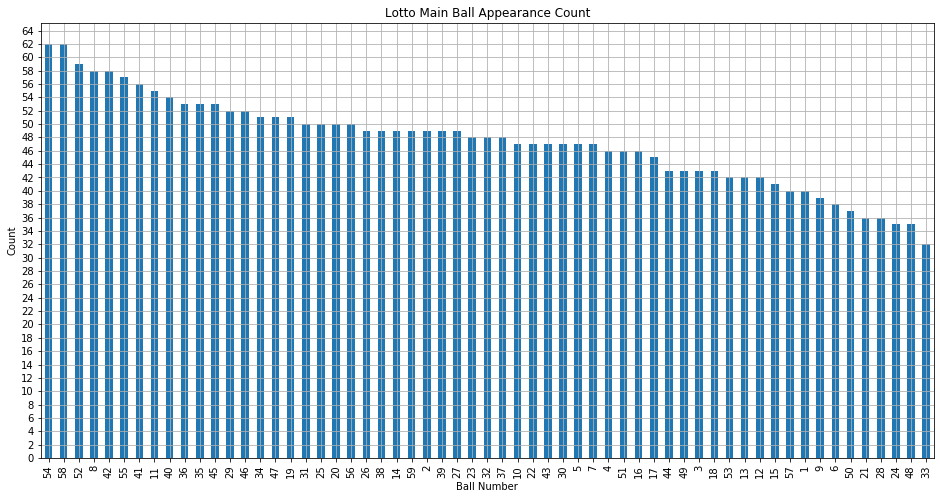

In [16]:
# Display a bar plot showing the number of times each ball has been drawn.
main_ball_count = results_df[["ball_1", "ball_2",
                              "ball_3", "ball_4",
                              "ball_5", "ball_6"]].stack().value_counts()
main_ball_count.plot(kind="bar", figsize=(16, 8),
                     title="Lotto Main Ball Appearance Count", grid=True,
                     yticks=range(0, 66, 2))
plt.xlabel("Ball Number")
plt.ylabel("Count")
plt.show()

The number of times each ball has appeared is shown in descending order from left to right. The most popular numbers were drawn 62 times and the least popular just 32 times.

In [17]:
# Get general stats on the main_ball_count data.
np.around(main_ball_count.describe(), decimals=1)

count    59.0
mean     47.4
std       6.8
min      32.0
25%      43.0
50%      48.0
75%      51.0
max      62.0
dtype: float64

The mean appearance count of the main balls was 47.4 and with a median of 48, outliers are not an issue. The interquartile range was a fairly narrow 8 appearances, with 50% of the balls being drawn between 43 and 51 times. However the range between least and most appearances is substantial at 30. This can be visualised with a box plot.

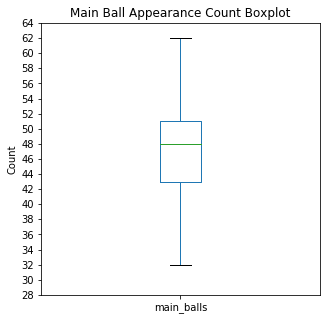

In [18]:
# Display a box plot for the main_ball_count data.
main_ball_count.plot(kind="box", figsize=(5, 5), yticks=range(28, 66, 2),
                     label="main_balls")
plt.title("Main Ball Appearance Count Boxplot")
plt.ylabel("Count")
plt.show()

### Common pairs

How often do the same pair of balls appear in Lotto draws?

In [19]:
# Create a counter to store the pairs and how often they occur.
pairs_counter = Counter()
# For each draw (row) in the main_balls column of the results_df, extract all
# possible pair combinations and add them to the counter.
for draw in results_df["main_balls"]:
    for combination in combinations(draw, 2):
        pairs_counter[combination] += 1

# Show the ten most common ball pairs from all draws in this dataset.
for pair in pairs_counter.most_common(10):
    print(f"{pair[0][0]} and {pair[0][1]}: {pair[1]} appearances")

2 and 54: 11 appearances
34 and 52: 11 appearances
14 and 19: 11 appearances
26 and 35: 11 appearances
7 and 47: 11 appearances
10 and 54: 10 appearances
42 and 58: 10 appearances
19 and 29: 10 appearances
27 and 36: 10 appearances
7 and 58: 10 appearances


A number of balls have appeared together 11 times (2% of the 466 draws).

### Time elapsed

Though one draw has no effect on another, some players might like to know how much time has passed since a ball has been drawn when picking their numbers.

In [20]:
# Function to get all the dates that a ball appeared in a draw.
def get_ball_draw_dates(ball_no):
    # Create boolean mask Series from the DataFrame showing True for a row if
    # the ball number has appeared in any of the main ball columns.
    ball_appeared_mask = results_df[["ball_1", "ball_2",
                                     "ball_3", "ball_4",
                                     "ball_5", "ball_6"]].isin([ball_no]).any(axis="columns")
    # For each True row in the mask, retreive its index value (i.e. the draw
    # date) and store it in a list.
    ball_drawn_dates = []
    for index, bool_value in ball_appeared_mask.items():
        if bool_value:
            ball_drawn_dates.append(index)
    return ball_drawn_dates

In [21]:
# Function to get the time in days between ball last being drawn and the
# present (taken to be the last draw in dataset, 25th March 2020, thus is hard
# coded into the function).
def get_days_last_appeared(ball_no):
    # Get all dates that the ball was drawn and store them in a list.
    drawn_dates = get_ball_draw_dates(ball_no)
    # As it is already ordered the most recent date that the ball appeared is
    # last in the list, so subract it from the "present" date.
    return (datetime(2020, 3, 25) - drawn_dates[-1]).days

In [22]:
# For each of the 59 balls get the number of days since it was last drawn and 
# store the value in a dictionary.
last_appeared = {}
for ball in range(1, 60):
    last_appeared[ball] = get_days_last_appeared(ball)

# Create a list that is sorted in descending order using the values of the
# dictionary.
last_appeared_sorted = sorted(last_appeared.items(), key=lambda item: item[1],
                              reverse=True)

# Show the top ten elements from the list.
for appearance in last_appeared_sorted[:10]:
    print(f"Ball {appearance[0]} appeared {appearance[1]} days ago.")

Ball 37 appeared 175 days ago.
Ball 17 appeared 126 days ago.
Ball 9 appeared 112 days ago.
Ball 6 appeared 109 days ago.
Ball 16 appeared 105 days ago.
Ball 1 appeared 88 days ago.
Ball 13 appeared 81 days ago.
Ball 15 appeared 70 days ago.
Ball 31 appeared 49 days ago.
Ball 8 appeared 46 days ago.


Five balls haven't appeared in a Lotto draw for over 100 days, with 37 being a long way in front having not appeared for 175 days. How does this compare to the time periods we might expect in general?

In [23]:
# Function to get the number of days between the same ball being drawn.
def get_days_between(ball_draw_dates_list):
    all_days_between = []
    for i in range(0, len(ball_draw_dates_list) - 1):
        days_between = (ball_draw_dates_list[i+1]
                        - ball_draw_dates_list[i]).days
        all_days_between.append(days_between)
    return all_days_between

In order to see whether the mean or median is best to represent the time between the same ball appearing, it is necessary to identify whether or not the data returned by the `get_days_between` function is normally distributed. In normal distributions, the plotted data forms a "bell curve" shape. It is symmetrical about the peak, denser near the centre and less so the further out you go. The mean and median values are equal, centrally located in the data. When the data is not normally distributed outliers can have an effect on the mean by pulling its value towards theirs, in which case the median offers a better representation. 

A quick visual method for doing this is to plot a histogram for a sample of random balls to see if the data fits the typical bell curve shape.

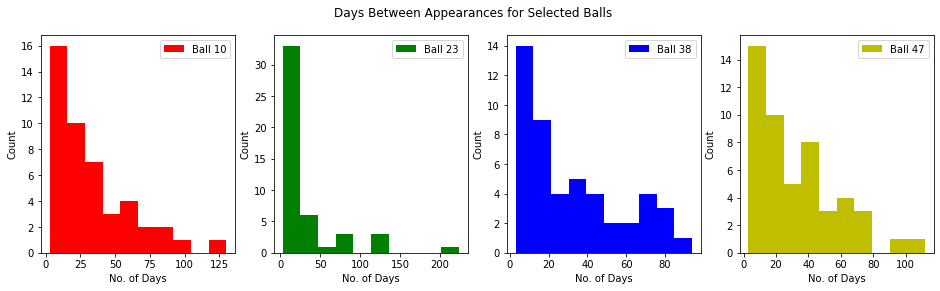

In [24]:
# Create figure and four subplots.
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
# Create lists for the four random balls, associated labels and plot colours.
random_balls = [10, 23, 38, 47]
random_balls_labels = [("Ball " + str(random_balls[x]))
                       for x in range(len(random_balls))]
colours = ['r', 'g', 'b', 'y']
# For each of the four subplots, create the histogram using the lists above.
for i in range(4):
    ax[i].hist(get_days_between(get_ball_draw_dates(random_balls[i])),
               color=colours[i], label=random_balls_labels[i])
    ax[i].set(xlabel="No. of Days", ylabel="Count")
    ax[i].legend()
# Common plot title.
fig.suptitle("Days Between Appearances for Selected Balls")
plt.show()

The data in these histograms does not appear to be normally distributed, but are positively skewed (skewed to the right). The mean values are likely to be higher due to the outliers, therefore the best measure of central tendancy that describes this data will be the median.

In [25]:
# For each of the 59 balls get the mean and median number of days between 
# its appearances and store the values in a dictionary.
stats_days_between = {}
for ball in range(1, 60):
    days_between = get_days_between(get_ball_draw_dates(ball))
    stats_days_between[ball] = (np.around(np.mean(days_between), decimals=1),
                                np.around(np.median(days_between), decimals=1))

# Show five examples from the dictionary.
for i in range(0, 5):
    print(stats_days_between.popitem())

(59, (32.7, 21.0))
(58, (26.4, 17.0))
(57, (40.8, 28.0))
(56, (32.0, 24.0))
(55, (28.4, 17.0))


The `stats_days_between` dictionary does indeed show that the mean values are higher than the median for every ball, confirming what the histograms above showed. 

In [26]:
# Get the median values from the stats_days_between dictionary.
median_days_between = []
for k, v in stats_days_between.items():
    median_days_between.append(v[1])

# Find the average of these median values.
np.around(np.mean(median_days_between), decimals=1)

24.8

Therefore 25 days is the approximate time to expect between the same ball being drawn.

Now to find the minimum and maximum time that has elapsed between the same ball appearing.

In [27]:
# Function to get the minimum and maximum number of days between the same ball
# being drawn.
def get_min_max_days_between(ball_draw_dates_list):
    # Get list of the number of days between each ball appearance.
    days_between = get_days_between(ball_draw_dates_list)
    # Return the min and max values in the list.
    return (min(days_between), max(days_between))

In [28]:
# For each of the 59 balls get the minimum and maximum number of days between 
# appearances and store them in a dictionary. 
min_max_days_elapsed = {}
for ball in range(1, 60):
    min_max_days_elapsed[ball] = get_min_max_days_between(get_ball_draw_dates(ball))

# Show five examples from the dictionary.
for i in range(0, 5):
    print(min_max_days_elapsed.popitem())

(59, (3, 217))
(58, (3, 115))
(57, (4, 224))
(56, (3, 147))
(55, (3, 112))


The overall minimum and maximum number of days between ball appearances can be found from this dictionary.

In [29]:
# Create a list containing just the minimum number of days between each ball 
# appearing from the dictionary.
min_days_elapsed = [x[0] for x in min_max_days_elapsed.values()]
# Find the minimum value.
print(f"Overall minimum days elapsed: {min(min_days_elapsed)}")

Overall minimum days elapsed: 3


In [30]:
# Create a list containing just the maximum number of days between each ball 
# appearing from the dictionary.
max_days_elapsed = [x[1] for x in min_max_days_elapsed.values()]
# Find the maximum value.
print(f"Overall maximum days elapsed: {max(max_days_elapsed)}")

Overall maximum days elapsed: 392


In general the least time that a ball has taken to appear again tends to be either three or four days, which is the time between draws (two each week). The longest time between appearances is expectedly more varied and Numpy can be used to confirm this.

In [31]:
print(f"Unique minimum elapsed days: {len(np.unique(min_days_elapsed))}")
print(f"Unique maximum elapsed days: {len(np.unique(max_days_elapsed))}")

Unique minimum elapsed days: 3
Unique maximum elapsed days: 32


Therefore visualising the maximum time between each ball appearing will be more useful than doing it for the minimum elapsed times.

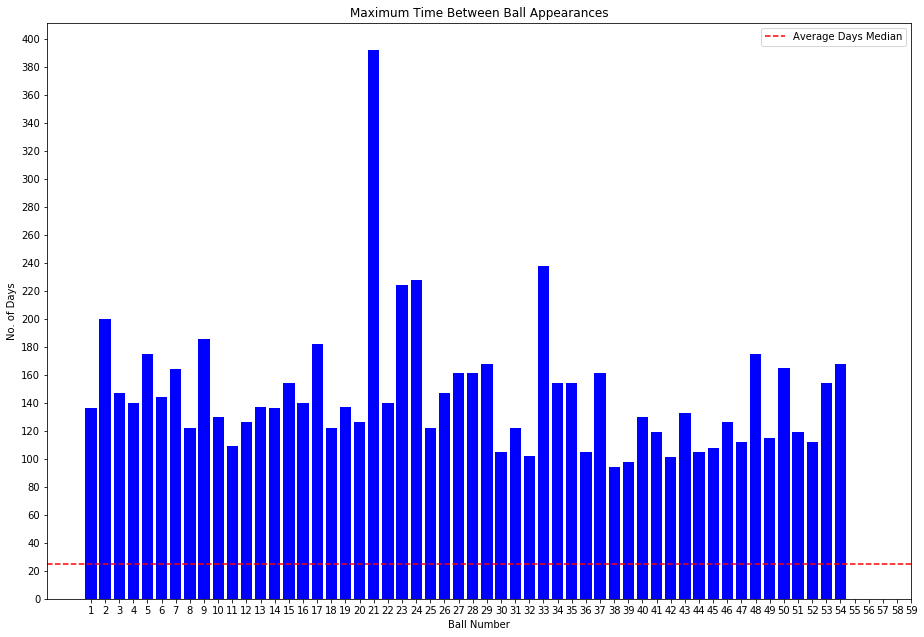

In [32]:
# Plot bar chart of maximum time elapsed between appearances for each ball and
# a horizontal line showing the average time elapsed between a ball 
# appearances as calculated earlier.
fig = plt.figure(figsize=(12, 8))
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(min_max_days_elapsed.keys(), max_days_elapsed, color='b')
ax.axhline(y=np.around(np.mean(median_days_between), decimals=1), color="r",
           label="Average Days Median", linestyle="--")
ax.set_title("Maximum Time Between Ball Appearances")
ax.set_xlabel("Ball Number")
ax.set_ylabel("No. of Days")
ax.set_xticks(range(1, 60))
ax.set_yticks(range(0, 420, 20))
ax.legend()
plt.show()

The red dotted line shows the approximate time expected between the same ball being drawn as calculated earlier (25 days). It serves to highlight how extreme the maximum elapsed times for each ball are.

### Top six

If the top six drawn numbers from all 466 draws in this dataset were known from the start and had been played each time, how many times would a prize have been won?

In [33]:
# Function to compare two ordered lists of unique numbers and return the number
# of matches.
def ticket_checker(draw_list, ticket_list):
    # Check if lists are of equal length.
    if len(draw_list) != len(ticket_list):
        # Lists unequal length, exit function.
        print("Lists unequal length.")
        return
    # Check each list contains only unique values.
    if (len(draw_list) != len(set(draw_list))) or (len(ticket_list) 
                                                   != len(set(ticket_list))):
        # At least one of the lists contains duplicate numbers, exit function.
        print("Lists contain duplicate numbers.")
        return
    # Ensure both lists are in ascending order.
    draw_list.sort()
    ticket_list.sort()
    # Check for matches.
    no_of_matches = 0
    index_draw = 0
    index_ticket = 0
    while (index_ticket <= (len(ticket_list)-1)) and (index_draw 
                                                      <= (len(draw_list)-1)):
        if ticket_list[index_ticket] == draw_list[index_draw]:
            # Numbers match, move onto next ball on ticket and in draw.
            no_of_matches += 1
            index_ticket += 1
            index_draw += 1
        elif ticket_list[index_ticket] > draw_list[index_draw]:
            # Ticket ball is higher than the drawn ball it is being compared 
            # to. Move onto next ball from draw.
            index_draw += 1
        else:
            # Ticket ball is lower than the drawn ball it is being compared 
            # to. Move onto next ball on ticket.
            index_ticket += 1
    return no_of_matches

In [34]:
# Top six numbers from 466 draws in this dataset as shown in the "Most
# appearances" section.
top_six_num = [8, 42, 52, 54, 55, 58]
# Check the top six numbers against each draw in the results_df.
wins_series = results_df["main_balls"].apply(lambda x:
                                             ticket_checker(x, top_six_num))
wins_series.value_counts()

0    200
1    187
2     69
3      9
4      1
Name: main_balls, dtype: int64

In [35]:
# Highlight the draws where the ticket matched three or four balls.
matches = (wins_series == 3) | (wins_series == 4)
wins_series[matches]

draw_date
2016-01-27    3
2017-03-25    3
2017-10-28    4
2017-12-30    3
2018-07-04    3
2018-09-15    3
2019-06-15    3
2020-01-15    3
2020-02-08    3
2020-02-29    3
Name: main_balls, dtype: int64

Prizes are given for matching two or more balls, so for the six most popular numbers, 79 tickets would have been winners. With each ticket costing £2, the outlay would have been £932. Two matched balls are rewarded with a free Lucky Dip ticket (which for this analysis I am assuming is a loss), so the only concrete return on the investment would have been £270 for the tickets matching three balls (each win £30) and £140 for the draw matching four balls. This gives a total loss of £522!

### Lucky Dip

In reality the top six numbers would not have been known until the 466 draws had occurred. The assumption that a Lucky Dip ticket would always give zero return is also clearly not the case, after all they are just six random computer generated numbers.

Players may have their favourite numbers or be part of syndicates which mean they play the same set of numbers each time. Alternatively they may simply pick their own random six numbers or take a chance on a Lucky Dip ticket. In all of these cases six random numbers are played, whether or not there appears to be method or reason to their choosing. They all have the same chance of winning a prize. So with that in mind how would a Lucky Dip ticket played across all 466 draws perform compared to the top six numbers above?

In [36]:
# Function to create Lucky Dip Lotto tickets.
def create_lucky_dip_tickets(no_of_tickets):
    # Create a list of balls 1-59.
    ball_numbers = range(1, 60)
    ticket_wallet = []
    for i in range(no_of_tickets):
        # Set the seed for reproducability purposes of this project.
        random.seed(i)
        # Create a random six number ticket from all 59 balls, sorted in 
        # ascending order.
        ticket = sorted(random.sample(ball_numbers, 6))
        ticket_wallet.append(ticket)
    # Return list of tickets.
    return ticket_wallet

To get more accurate results, 100 Lucky Dip tickets will be created and checked against all the draws.

In [37]:
# Create 100 Lucky Dip tickets.
my_lucky_dip_tickets = create_lucky_dip_tickets(100)

# Show the first five tickets.
my_lucky_dip_tickets[:5]

[[3, 17, 25, 27, 49, 55],
 [5, 9, 37, 49, 52, 55],
 [4, 6, 24, 55, 56, 59],
 [9, 16, 24, 35, 38, 39],
 [7, 16, 20, 26, 31, 47]]

In [38]:
# Function to check each Lucky Dip ticket in a list against all the draws in 
# the results_df DataFrame.
def check_lucky_dip_tickets(list_of_tickets):
    # Create a dictionary to hold the results and a counter to name the keys.
    lucky_dip_results = {}
    ticket_no = 1
    for ticket in list_of_tickets:
        # Use the ticket_checker() function to check the current ticket against 
        # all draws in the DataFrame.
        lucky_dip_series = results_df["main_balls"].apply(lambda x: ticket_checker(x, ticket))
        # Add the results to the dictionary.
        lucky_dip_results[("ticket_" + str(ticket_no))] = [ticket, lucky_dip_series.value_counts()]
        ticket_no += 1
    return lucky_dip_results

In [39]:
# Check how the Lucky Dip tickets would have fared in the 466 draws.
hundred_results_dict = check_lucky_dip_tickets(my_lucky_dip_tickets)

# Show five examples from the dictionary.
for i in range(0, 5):
    print(hundred_results_dict.popitem())

('ticket_100', [[12, 13, 15, 25, 26, 39], 0    251
1    163
2     46
3      6
Name: main_balls, dtype: int64])
('ticket_99', [[3, 23, 27, 37, 54, 59], 0    232
1    179
2     45
3     10
Name: main_balls, dtype: int64])
('ticket_98', [[13, 24, 28, 52, 53, 54], 0    241
1    176
2     47
3      2
Name: main_balls, dtype: int64])
('ticket_97', [[7, 14, 21, 24, 26, 44], 0    264
1    149
2     49
3      4
Name: main_balls, dtype: int64])
('ticket_96', [[33, 35, 48, 49, 51, 58], 0    241
1    180
2     44
3      1
Name: main_balls, dtype: int64])


In [40]:
############################ TODO CONTINUE REVIEW FROM HERE:

Although some Lucky Dip tickets matched four balls, to be conservative I will just focus on the number of times any winning tickets matched three balls and use an average value to adjust the total return calculated earlier. 

In [41]:
# For each ticket, access the value count in the dictionary corresponding to three matches.
three_matches_count = []
for ticket in hundred_results_dict:
    # Check if the ticket has any three-ball matches using the lucky_dip_series.value_counts() value in the dictionary (hundred_results_dict[ticket][1]).
    if 3 in hundred_results_dict[ticket][1].index:
        three_matches_count.append(hundred_results_dict[ticket][1][3])
    else:
        three_matches_count.append(0)

# Calculate the average by summing the list and dividing by the number of elements.
print(f"Average three balls matched: {sum(three_matches_count) / len(three_matches_count)}")

Average three balls matched: 5.473684210526316


Based on one hundred Lucky Dip tickets, three balls might be matched 5.43 times in 466 draws giving a win ratio of approximately 1:86. Given this ratio and the fact that the top six numbers played earlier only provided 69 free Lucky Dip tickets, the previous assumption that they would give no monetary return is fair in this basic analysis.

## Summary